In [1]:
!pip3 install transformers pandas torch tqdm


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, TextClassificationPipeline
import torch
from tqdm import tqdm

df = pd.read_csv("IndianFinancialNews.csv")
df['text'] = df['Title'].fillna('') + '. ' + df['Description'].fillna('')

model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

def classify_with_mps(texts, model, tokenizer):
    results = []
    model.eval()
    with torch.no_grad():
        for text in tqdm(texts, desc="Auto-labeling"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            label_idx = torch.argmax(probs).item()
            label = ['positive', 'negative', 'neutral'][label_idx]
            results.append(label)
    return results

df['predicted_label'] = classify_with_mps(df['text'].tolist(), model, tokenizer)

df[['Date', 'Title', 'Description', 'predicted_label']].to_csv("auto_labeled_financial_news.csv", index=False)
print("✅ Auto-labeling complete and saved to auto_labeled_financial_news.csv")

/Users/karanthakkar/Desktop/projects/News-Sentiment-and-Stock-Price-Trend-Classification-using-Deep-Learning/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Auto-labeling: 100%|██████████| 50000/50000 [19:16<00:00, 43.22it/s]


✅ Auto-labeling complete and saved to auto_labeled_financial_news.csv


In [ ]:
import pandas as pd

df = pd.read_csv("auto_labeled_financial_news.csv")

df['text'] = df['Title'].fillna('') + '. ' + df['Description'].fillna('')
df = df[df['text'].str.strip() != '']

df = df[['text', 'predicted_label']]

In [ ]:
label2id = {'positive': 0, 'negative': 1, 'neutral': 2}
df = df[df['predicted_label'].isin(label2id.keys())]  
df['label'] = df['predicted_label'].map(label2id)

In [ ]:
def clean(text):
    text = str(text)
    text = text.replace('\n', ' ').replace('\r', ' ')  
    text = text.strip()
    return text

df['text'] = df['text'].apply(clean)

In [6]:
df[['text', 'label']].to_csv("cleaned_finbert_dataset.csv", index=False)

In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_finbert_dataset.csv")

print(f"Total samples: {len(df)}")

label_map = {0: "positive", 1: "negative", 2: "neutral"}
label_counts = df['label'].value_counts().sort_index()

for label_id, count in label_counts.items():
    label_name = label_map[label_id]
    percent = (count / len(df)) * 100
    print(f"{label_name:>8}: {count} samples ({percent:.2f}%)")

Total samples: 50000
positive: 16786 samples (33.57%)
negative: 12140 samples (24.28%)
 neutral: 21074 samples (42.15%)


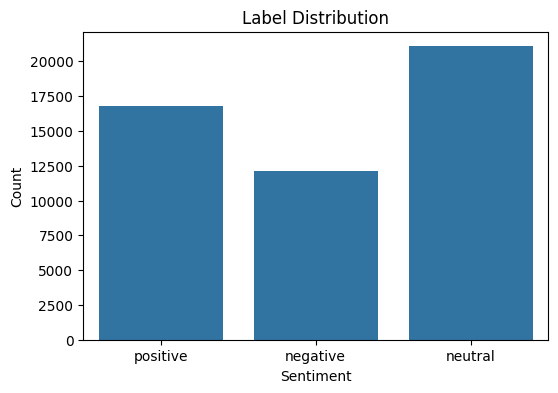

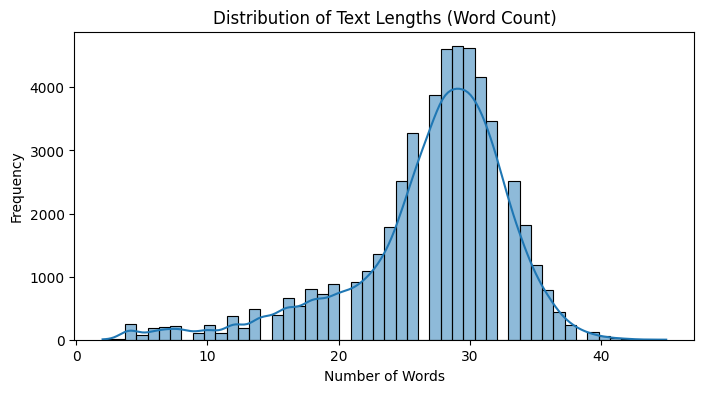

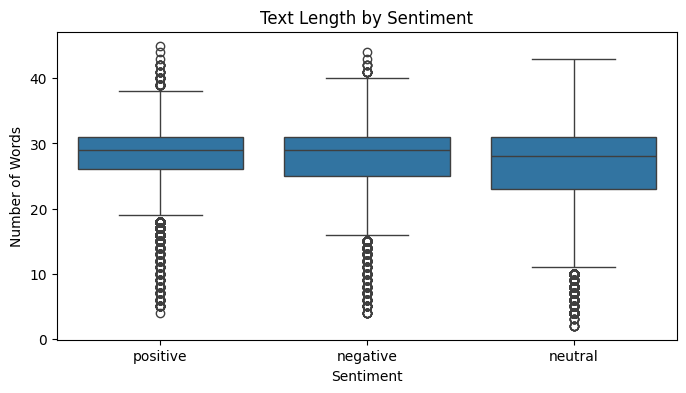

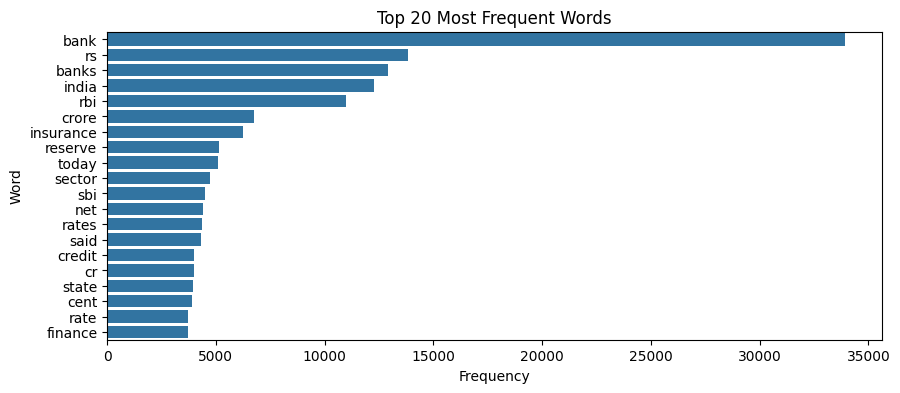

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_finbert_dataset.csv")

label_map = {0: "positive", 1: "negative", 2: "neutral"}
df['label_name'] = df['label'].map(label_map)

plt.figure(figsize=(6, 4))
sns.countplot(x='label_name', data=df, order=["positive", "negative", "neutral"])
plt.title("Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='label_name', y='text_length', data=df, order=["positive", "negative", "neutral"])
plt.title("Text Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])

word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

word_df = pd.DataFrame({'word': words, 'freq': word_freq}).sort_values(by='freq', ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x='freq', y='word', data=word_df)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

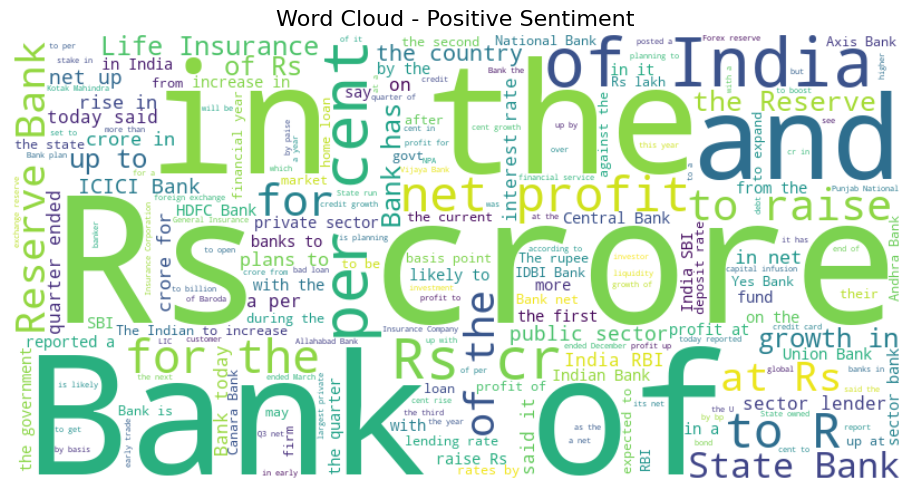

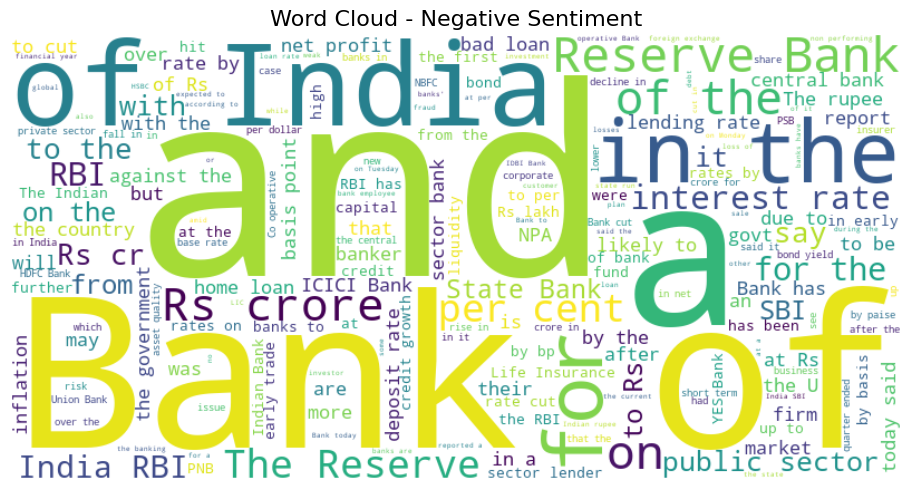

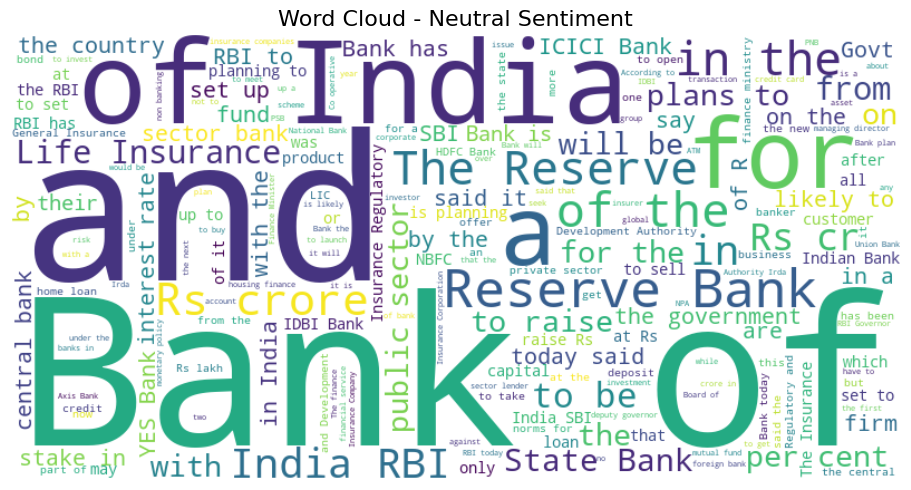

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text_data, title):
    text = " ".join(text_data)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for label_id, label_name in label_map.items():
    generate_wordcloud(df[df['label'] == label_id]['text'], f"Word Cloud - {label_name.capitalize()} Sentiment")

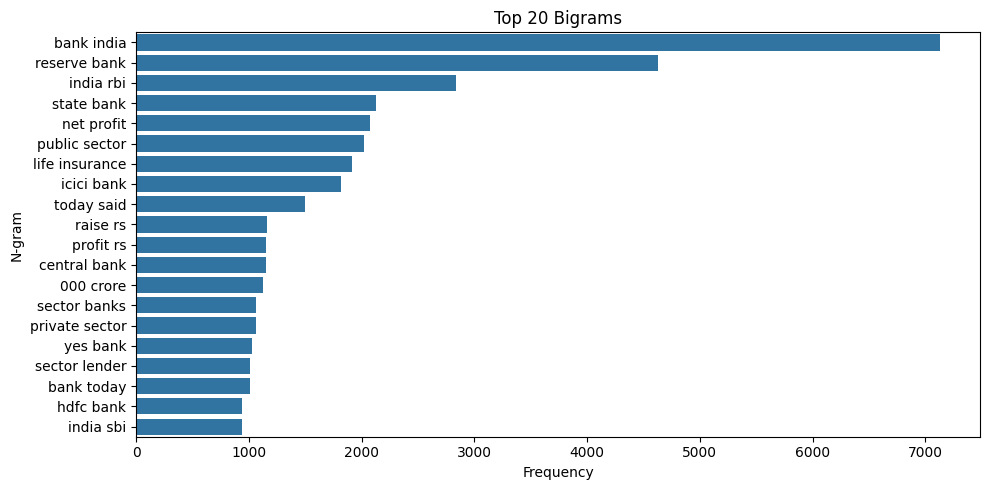

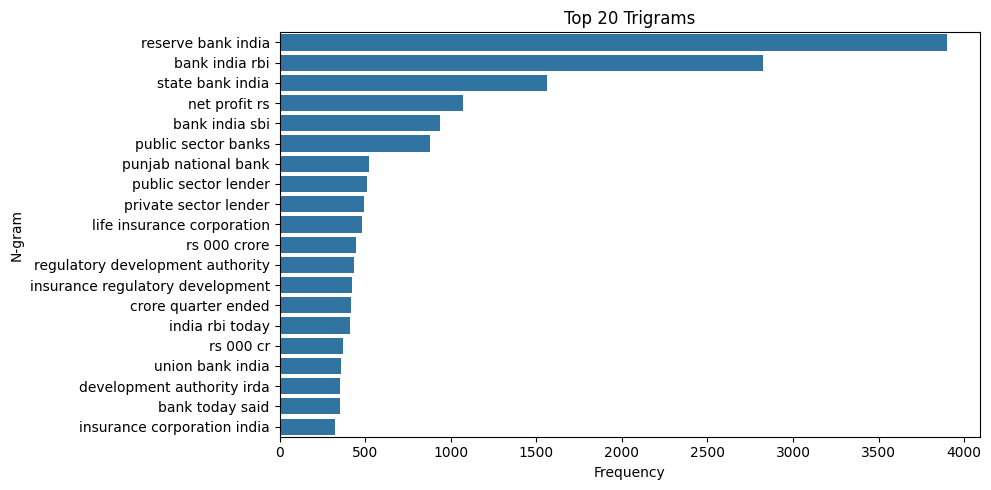

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

def plot_ngrams(corpus, ngram_range=(2,2), top_k=20, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_counts = vec.fit_transform(corpus)
    sum_counts = ngram_counts.sum(axis=0).A1
    ngrams = vec.get_feature_names_out()
    
    ngram_freq = pd.DataFrame({'ngram': ngrams, 'count': sum_counts})
    ngram_freq = ngram_freq.sort_values(by='count', ascending=False).head(top_k)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='count', y='ngram', data=ngram_freq)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

plot_ngrams(df['text'], ngram_range=(2, 2), title="Top 20 Bigrams")
plot_ngrams(df['text'], ngram_range=(3, 3), title="Top 20 Trigrams")

In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_finbert_dataset.csv")

print(f"Total samples: {len(df)}")
label_map = {0: "positive", 1: "negative", 2: "neutral"}
label_counts = df['label'].value_counts().sort_index()
for label_id, count in label_counts.items():
    print(f"{label_map[label_id]:>8}: {count} samples ({(count / len(df)) * 100:.2f}%)")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Total samples: 50000
positive: 16786 samples (33.57%)
negative: 12140 samples (24.28%)
 neutral: 21074 samples (42.15%)


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], stratify=df['label'], test_size=0.30, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, stratify=temp_labels, test_size=0.50, random_state=42
)

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
val_dataset = Dataset.from_dict({'text': val_texts.tolist(), 'label': val_labels.tolist()})
test_dataset = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=64)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 7500/7500 [00:01<00:00, 4583.14 examples/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='macro')
    }

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

In [25]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finbert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/2z/nkbbg5g56z389ncv_bhg353m0000gn/T/ipykernel_99856/2375350960.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.267200,0.246039,0.898267,0.899039
2,0.134300,0.267364,0.904533,0.905035
3,0.074200,0.359381,0.907067,0.907415


KeyboardInterrupt: 

In [30]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.3593811094760895, 'eval_accuracy': 0.9070666666666667, 'eval_f1': 0.9074148824175343}


In [ ]:
import torch

trained_model = trainer.model
trained_model.eval()

id2label = {0: "positive", 1: "negative", 2: "neutral"}

In [ ]:
def predict_sentiment(texts, return_probs=False):
    import torch

    if isinstance(texts, str):
        texts = [texts]

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    trained_model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = trained_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    labels = [id2label[p.item()] for p in preds]
    confidences = probs.max(dim=1).values.tolist()

    if return_probs:
        return list(zip(labels, confidences))
    else:
        return labels

In [33]:
samples = [
    "Indian rupee to slide again after brief recovery, erasing nearly all gains: Reuters poll",
    "Republicans Eye $25,000 SALT Cap as Trump’s Tax Cuts Take Shape",
    "Global Uncertainty And Impact On Indian Financial Markets Read — CareEdge's Analysis"
]

preds = predict_sentiment(samples)

for text, label in zip(samples, preds):
    print(f"{label.upper():<8} — {text}")

NEGATIVE — Indian rupee to slide again after brief recovery, erasing nearly all gains: Reuters poll
NEUTRAL  — Republicans Eye $25,000 SALT Cap as Trump’s Tax Cuts Take Shape
NEUTRAL  — Global Uncertainty And Impact On Indian Financial Markets Read — CareEdge's Analysis


In [34]:
!pip3 install yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.6-py312-none-any.whl.metadata (23 kB)
  Using cached peewee-3.17.9-cp312-cp312-macosx_10_9_universal2.whl
Using cached frozendict-2.4.6-py312-none-any.whl (16 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [36]:
!pip3 install googlenews


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import yfinance as yf
from GoogleNews import GoogleNews
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def get_company_name(ticker):
    try:
        info = yf.Ticker(ticker).info
        return info.get('longName', ticker)
    except:
        return ticker

def get_news_from_google(query, num_results=10, days_back=1):
    googlenews = GoogleNews(lang='en')
    googlenews.set_time_range(f"{days_back}d", f"{days_back}d")
    googlenews.clear()
    googlenews.search(query)
    articles = googlenews.result()[:num_results]

    headlines = []
    urls = []
    dates = []

    for a in articles:
        if a['title'].strip():
            headlines.append(a['title'])
            urls.append(a.get('link', 'N/A'))

            # Try parsing the date, fallback to today if missing
            raw_date = a.get('date', '')
            try:
                parsed_date = pd.to_datetime(raw_date)
            except:
                parsed_date = pd.Timestamp.today()

            dates.append(parsed_date)

    return headlines, urls, dates

def analyze_news_sentiment(ticker, num_articles=10, days_back=1):
    company = get_company_name(ticker)
    headlines, urls, dates = get_news_from_google(company, num_results=num_articles, days_back=days_back)

    if not headlines:
        print("No news found.")
        return None

    sentiments_with_conf = predict_sentiment(headlines, return_probs=True)
    sentiments, confidences = zip(*sentiments_with_conf)

    df = pd.DataFrame({
        'Date': dates,
        'Headline': headlines,
        'URL': urls,
        'Sentiment': sentiments,
        'Confidence': [round(c, 3) for c in confidences]
    })

    # Sort by date descending (latest first)
    df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)

    # Save to CSV
    filename = f"{ticker.upper()}_news_sentiment.csv"
    df.to_csv(filename, index=False)
    print(f"Saved sentiment results to {filename}")

    # Visualization
    plt.figure(figsize=(6, 6))
    df['Sentiment'].value_counts().plot.pie(
        autopct='%1.1f%%',
        startangle=140,
        explode=[0.05]*3
    )
    plt.title(f"Sentiment Distribution for {company} (Last {days_back} Day{'s' if days_back > 1 else ''})")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    return df

✅ Saved sentiment results to RELIANCE.NS_news_sentiment.csv


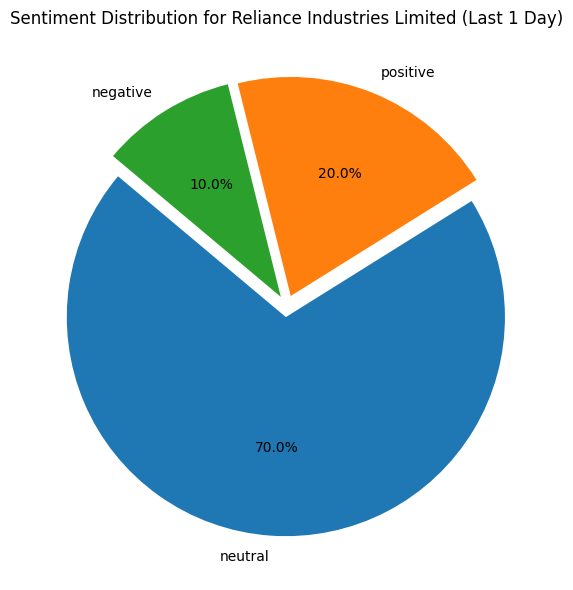

,Date,Headline,URL,Sentiment,Confidence
0,2025-04-01 20:59:24.386406,Masterstroke by Mukesh Ambani as Reliance Jio ...,https://www.india.com/news/masterstroke-by-muk...,positive,0.998
1,2025-04-01 20:59:24.386362,Mukesh Ambani-led Reliance Industries transfer...,https://www.dnaindia.com/business/report-big-m...,neutral,1.000
2,2025-04-01 20:59:24.386322,Reliance Industries Limited (RIL) reduces Poly...,https://www.polymerupdate.com/News/Details/137...,negative,0.909
3,2025-04-01 20:59:24.386277,Anant Ambani leads 140-km ‘padyatra’ from Jamn...,https://www.hindustantimes.com/india-news/anan...,neutral,1.000
4,2025-04-01 20:59:24.386235,Anant Ambani undertakes a 'padyatra' from Jamn...,https://www.aninews.in/news/national/general-n...,neutral,0.999
5,2025-04-01 20:59:24.386192,Mukesh Ambani stock to buy now for an upside p...,https://tradebrains.in/mukesh-ambani-stock-to-...,neutral,1.000
6,2025-04-01 20:59:24.386145,Anant Ambani Embarks on 140-km Spiritual Paday...,https://liveindia.tv/news/anant-ambani-embarks...,neutral,1.000
7,2025-04-01 20:59:24.386093,"Rs 10,167 crore order book: Reliance Group-bac...",https://www.dsij.in/dsijarticledetail/rs-10167...,positive,1.000
8,2025-04-01 20:59:24.386026,Reliance Industries Limited,https://www.facebook.com/RelianceIndustriesLim...,neutral,1.000
9,2025-04-01 20:59:24.385813,Reliance's Anant Ambani Begins Padyatra to Dwa...,https://www.thehansindia.com/news/national/rel...,neutral,1.000


In [49]:
analyze_news_sentiment("RELIANCE.NS", num_articles=15, days_back=1)

✅ Saved sentiment results to AAPL_news_sentiment.csv


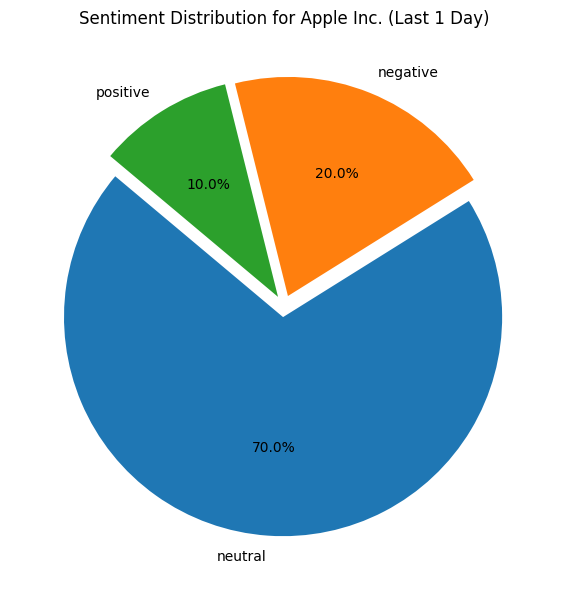

,Date,Headline,URL,Sentiment,Confidence
0,2025-04-01 21:01:57.930850,Apple iPhone sales slip in February amid weak ...,https://www.proactiveinvestors.com/companies/n...,negative,1.000
1,2025-04-01 21:01:57.930814,EXCLUSIVE: Tema ETF Tackles Mag 7 Concentratio...,https://www.benzinga.com/analyst-ratings/analy...,neutral,1.000
2,2025-04-01 21:01:57.930778,Apple issues fixes for vulnerabilities in both...,https://cyberscoop.com/apple-security-update-m...,neutral,1.000
3,2025-04-01 21:01:57.930742,Apple: Great Business But The Wrong Price (NAS...,https://seekingalpha.com/article/4772327-apple...,neutral,1.000
4,2025-04-01 21:01:57.930707,"Visa, American Express seek to swipe Apple cre...",https://seekingalpha.com/news/4427715-visa-ame...,neutral,1.000
5,2025-04-01 21:01:57.930670,Visa said to have offered $100M to get Apple's...,https://breakingthenews.net/Article/Visa-said-...,positive,0.828
6,2025-04-01 21:01:57.930632,Jim Cramer on Apple Inc. (NASDAQ:AAPL): “Apple...,https://finance.yahoo.com/news/jim-cramer-appl...,neutral,0.877
7,2025-04-01 21:01:57.930591,Financials Down on Tariff Anxiety -- Financial...,https://www.marketscreener.com/quote/stock/APP...,negative,0.999
8,2025-04-01 21:01:57.930544,Visa Eyes Apple's Credit Card Business With $1...,https://finimize.com/content/visa-eyes-apples-...,neutral,1.000
9,2025-04-01 21:01:57.930480,EXCLUSIVE: March's 20 Most-Searched Tickers On...,https://www.benzinga.com/trading-ideas/25/04/4...,neutral,1.000


In [50]:
analyze_news_sentiment("AAPL", num_articles=15, days_back=1)